# Fat tails of Equity Returns and Robust Regression

Today we will work with equity data. We will try to find the **optimal hedge ratio** between two stock indexes.

We will compare a least squares estimator to a **robust** estimator based on Student's T distribution that is designed to model the non-Gaussianity of equity returns. 

We will see that:
1. Hedge rations (regressions coefficients) are different between both regressors.
1. The robust estimator performs better out of sample.
1. The differences, however, are small.
1. We will then discuss be the non-stationarity of the time series data.

We will work with a model 
$$
    y_t = \theta_0 + \theta_1 x_t + \epsilon_t
$$

where we will assume that the *innovations* $\epsilon$
1. have zero mean
2. are independent for $t\ne t'$
3. Are identically distributed
4. Non necessarily Gaussian.
 

#### Target and Predictor Index

In [1]:
target= "RU3000V" # Rusell 3,000 Value Stocks Index
predictor="RU3000G" # Rusell 3,000 Growth Stocks Index

####  Define Train and Test Period

In [2]:
# test before presidential election 2016: 8 Nov 2016
from datetime import date
test_date0=date(2014,10,30)
test_date1=date(2016,10,30)

## Preliminaries

### Imports

In [3]:


import numpy as np
import pandas as pd
import scipy.optimize

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy import special

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots

%matplotlib inline

/home/manel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data

In [4]:
data_dir="../../data/finance"

In [5]:
eqLevels=pd.read_csv(data_dir+"/RussellIndexes.csv",index_col=[0],parse_dates=[0])
eqLevels.head()

,RU3000,RU2000,RU1000V,RU1000,RU2000V,RU1000G,RUMIDCAP,RU2000G,RU3000V,RMIDGR,RMIDVL,RU3000G
DATE,,,,,,,,,,,,
1995-05-31,1032.69,982.04,192.75,1036.37,1203.23,181.34,1242.92,1190.50,1000.00,338.75,328.35,1000.00
1995-06-01,1034.42,986.60,193.05,1037.77,1209.42,181.55,1246.34,1195.46,1001.91,339.98,329.00,1001.45
1995-06-02,1034.56,989.48,192.99,1037.61,1212.55,181.54,1247.38,1199.32,1001.90,340.23,329.30,1001.72
1995-06-05,1041.21,996.50,194.27,1044.21,1219.08,182.66,1259.02,1209.81,1008.40,343.85,331.99,1008.11
1995-06-06,1041.04,998.22,194.20,1043.82,1221.69,182.59,1258.83,1211.42,1008.28,343.47,332.23,1007.89


In [6]:
eqReturns=np.log(1+eqLevels.pct_change()).dropna()
eqReturns.head()

,RU3000,RU2000,RU1000V,RU1000,RU2000V,RU1000G,RUMIDCAP,RU2000G,RU3000V,RMIDGR,RMIDVL,RU3000G
DATE,,,,,,,,,,,,
1995-06-01,0.001674,0.004633,0.001555,0.001350,0.005131,0.001157,0.002748,0.004158,0.001908,0.003624,0.001978,0.001449
1995-06-02,0.000135,0.002915,-0.000311,-0.000154,0.002585,-0.000055,0.000834,0.003224,-0.000010,0.000735,0.000911,0.000270
1995-06-05,0.006407,0.007070,0.006611,0.006341,0.005371,0.006150,0.009288,0.008709,0.006467,0.010584,0.008136,0.006359
1995-06-06,-0.000163,0.001725,-0.000360,-0.000374,0.002139,-0.000383,-0.000151,0.001330,-0.000119,-0.001106,0.000723,-0.000218
1995-06-07,-0.003686,0.000571,-0.006665,-0.004147,-0.001343,-0.001809,-0.002394,0.002399,-0.006158,0.000931,-0.005372,-0.001360


#### Training Data

In [7]:
X_train=eqReturns[:test_date0][predictor]
Y_train=eqReturns[:test_date0][target]
X_train.shape,Y_train.shape

((4904,), (4904,))

#### Test Data

In [8]:
X_test=eqReturns[test_date0:test_date1][predictor]
Y_test=eqReturns[test_date0:test_date1][target]
X_test.shape,Y_test.shape

((504,), (504,))

## Least Squares regression model of Equity Returns

 [Seaborn](https://seaborn.pydata.org/examples/index.html) library is specialized in statistical data visualization.
 
 We will use is in this notebook to quickly visualize the data.
 
The relationship between $X$ and $Y$ in the training set seems roughly linear, so our linear model is justified
 
 $$
     y_t = \theta_0+ \theta_1 x_t + \epsilon_t
 $$

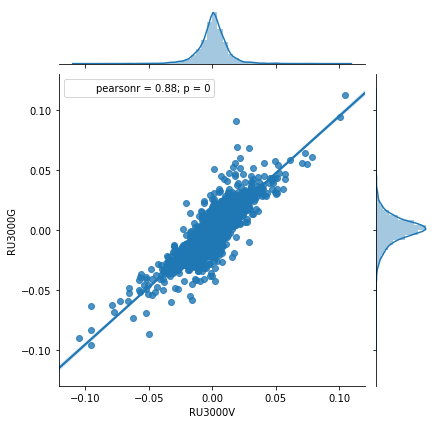

In [9]:
sns.jointplot(x=Y_train,y=X_train,kind="reg")

We can select the optimal parameters my minimizing the **mean squared error**

\begin{equation}
    \hat{\theta}_{\textrm{N}} = \textrm{argmin}_{\theta_0,\theta_1} \frac{1}{2N}\sum_i (y_i - \theta_0 - \theta_1 x_i)^2
\end{equation}

If we assume that $\epsilon$ is $\mathcal{N}(0;s^2)$ distributed, we know that this estimator is the *maximum likelihood estimator*. 

But, even when $\epsilon$ is not Gaussian the mean square error estimator is still
1. Unbiased 
2. Lowest variance of all possible *linear* estimators of $\theta_0$, $\theta_1$.
                                                       

We can fit this model easily using `sklearn`'s linear regression model. 

In [10]:
model_normal=linear_model.LinearRegression()

In [11]:
 # linear model complains if we pass a N vector for X,
# it really wants a N x 1 matrix
                 
model_normal.fit(X_train.values.reshape(-1,1),Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
Y_pred=model_normal.predict(X_train.values.reshape(-1,1))
np.sqrt(mean_squared_error(Y_pred,Y_train))

0.005951811579257517

#### Distribution of Regression Residual

In [13]:
err_normal=Y_train-Y_pred
err_normal.name="LSQ Residual"


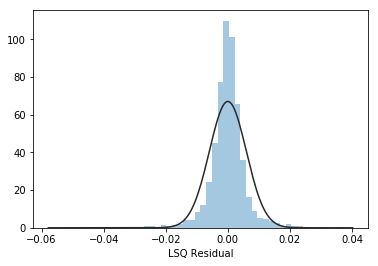

In [14]:
sns.distplot(err_normal,fit=stats.norm,kde=False,norm_hist=True)

The residuals, however, **do not fit a Normal distribution** very well.

The points with **high leverage** ($X$ furthers from mean) could dominate correlation results.

##  Modelling the Residual Empirical Distribution

### The t-distribtion

The centered t-distribution is a generalization of the Gaussian distribution that has **fat tails**. It has pdf
$$
    P_{t}(t; \nu, s) = \frac{1}{\sqrt{\nu s}B(\frac{1}{2},\frac{\nu}{2})}
         \left( 1 + \frac{t^2}{\nu s^2}\right)^{-\frac{\nu+1}{2}}
$$
where $B(\alpha,\beta)$ is the beta function.

The Gaussian distribution is the special case
$$
    \lim_{\nu \rightarrow \infty} P_{t}(t;\nu,s) = \mathcal{N}(t;0,s^2)
$$
so the parameter $s$ has the interpretation of the standard deviation $\sigma$.

When $\nu$ is finite, t-student distribution falls for large values $t$ as a power law
$$
     P_t(t;\nu,s) \approx |t|^{-\nu+1} \text{ as } t \rightarrow \infty
$$
which is much slower than the exponential rate of the Gaussian distribution
$$
    \mathcal{N}(t;0,\sigma^2)  \approx e^{- \frac{1}{2}\frac{t^2}{s^2}} \text{ as } t \rightarrow \infty.
$$   

We has thus the following facts about t-student distribution
1. t-Student is a genearalization of the Gaussian
2. the parameter $s$ plays the role


### Empirical Fit of residuals to t-Student distribution

The residuals of the LSQ regression fit well a t-student's distribution


The method [`seaborn.distplot`](https://seaborn.pydata.org/generated/seaborn.distplot.html) allows us to quickly visualize a dataset distribution and the fit to any distribution chosen from [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html)large collection of distributions.

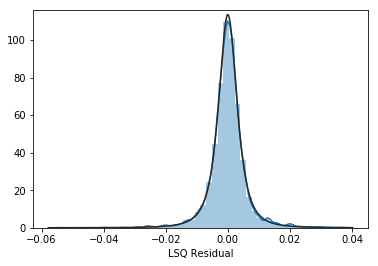

In [15]:
sns.distplot(err_normal,fit=stats.t)

### Comparison of Normal and t-Student residual fit

Now, we will do will call the `stats` fit method ourselves 
so that we have better control of the plot appearance.

In [16]:
r=np.arange(-0.03,0.03,0.04/201)

In [17]:
parms_normal=stats.norm.fit(err_normal)
print("Normal Parameters",*parms_normal)
dist_normal=stats.norm(*parms_normal)
pdf_normal=dist_normal.pdf(r)

Normal Parameters -3.3958697735271914e-20 0.005951811579257517


In [18]:
parms=stats.t.fit(err_normal)
print("T-Student Parameters",*parms)
dist=stats.t(*parms)
pdf=dist.pdf(r)

T-Student Parameters 2.3505293373931178 -2.7306914358343355e-20 0.003159162271009154


Text(0,0.5,'pdf')

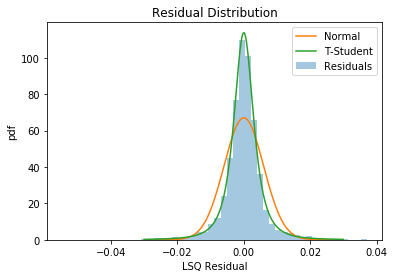

In [19]:
sns.distplot(err_normal,kde=False,norm_hist=True,label="Residuals")
plt.plot(r,pdf_normal,label="Normal")
plt.plot(r,pdf,label="T-Student")
plt.legend()
plt.title("Residual Distribution")
plt.ylabel("pdf")

#### Tail Comparison of both distributions

The rate of decay of the tails is easier to appreciate on a log plot 

Text(0,0.5,'Log(pdf)')

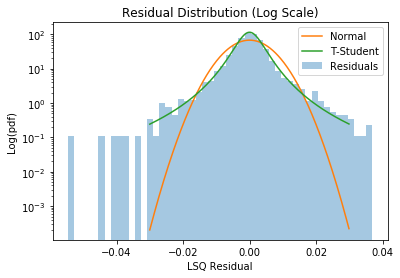

In [20]:
sns.distplot(err_normal,kde=False,norm_hist=True,label="Residuals")
plt.plot(r,pdf_normal,label="Normal")
plt.plot(r,pdf,label="T-Student")
plt.legend()
ax=plt.gca()
ax.set_yscale("log", nonposy='clip')
plt.title("Residual Distribution (Log Scale)")
plt.ylabel("Log(pdf)")

#### Robust Estimation Penalty

The squared loss puts a large penalty on observations that are far from the mean because they are very unlikely for a Gaussian distribution.

A **robust estimator** has a penalty that does not grow as fast as $t^2$ for large $t$.

We can, for example, build a robust estimator by fitting a t-student distribution to the residuals.

We can, alternatively, use a predefined robust loss like the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss estimator like [`sklear.linear_model.HuberRegressor`]), and the associated [`sklearn.linear_model.HuberRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html), but then we will need to estimate a hyper-parameter $\Delta$ which is equivalent to fitting $\nu$ on the t-Student distribution.

Text(0,0.5,'Loss')

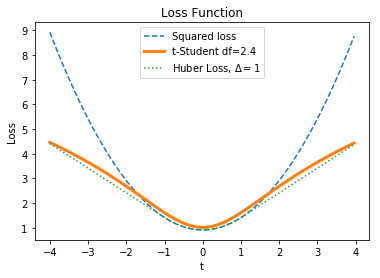

In [21]:
df=parms[0]
t=np.arange(-4,4,8.0/201)
E0=-np.log(stats.norm.pdf(0,loc=0,scale=1)) # gaussian loss at t=0
plt.plot(t,-np.log(stats.norm.pdf(t,loc=0,scale=1)),linestyle="--",label="Squared loss")
plt.plot(t,-np.log(stats.t.pdf(t,df=df)),label=f"t-Student df={df:0.2}",linewidth=3 )
plt.plot(t,E0+special.huber(1,t),label="Huber Loss, $\Delta=1$",linestyle=":")
plt.legend()
plt.title("Loss Function")
plt.xlabel("t")
plt.ylabel("Loss")

Using the pre-build Huber robust regressor is more convenient, but here, for practice, we will construct a maximum likelihood regressor based on the t-student distribution.


## A Maximum Likelihood Estimator for Hedge Ratio

We now come back to our model

$$
 y_t = \theta_0 + \theta_1 x_t + \epsilon_t
$$



### A Gausian Maximum Likelihood Estimator

First, to test the machinery. We will build a maximum likelihood estimator under the assumption that residuals are Gaussian.

We know that this should be equivalent to least square estimator we build before. We do it just as **a test** that we know how to use `scipy.stats` distributions together with  `scipy.optimize` to build the maximum likelihood estimator.

Our error function will be
$$
    E_{\textrm{Normal}}(\Theta;\{x_t,y_t\})= \frac{1}{N} -\log \mathcal{N}(y_t -\theta_0 - \theta_1 x_t;0, \sigma^2)
$$
and we will optimize for $\Theta=(\theta_0,\theta_1,\log \sigma )$. 

We use *unconstrained* optimization, but optimize $\log\sigma$ to ensure that $\sigma$ is positive.
We could, instead, had optimized on $\sigma$ but used  *constrained* optimization.

The end result should be **identical** to the least square optimization we did before.

In [22]:
def params_to_x_normal(theta0,theta1,scale):
    x=np.empty(3)
    x[0]=theta0
    x[1]=theta1
    x[2]=np.log(scale) # to enforce that \sigma
    return x
def x_to_params_normal(x):
    theta0=x[0]
    theta1=x[1]
    scale=np.exp(x[2])
    return theta0,theta1,scale
def objective_function_normal(x,X,Y):
    theta0,theta1,scale=x_to_params_normal(x)
    residual=Y-theta0-theta1*X.ravel() # because Y is 1-dimensional, here numpy was X to have only one index
    parms=(0.0,scale)
    dist=stats.norm(*parms)
    err=dist.logpdf(residual)
    return -err.mean()

In [23]:
theta0_guess_normal=0
theta1_guess_normal=0
scale_guess_normal=0.05
theta0_guess_normal,theta1_guess_normal,scale_guess_normal

(0, 0, 0.05)

In [24]:
x0_normal=params_to_x_normal(theta0_guess_normal,theta1_guess_normal,scale_guess_normal)
x0_normal

array([ 0.        ,  0.        , -2.99573227])

In [25]:
fit_normal=scipy.optimize.minimize(objective_function_normal,x0_normal,args=(X_train,Y_train))
fit_normal

      fun: -3.705121105457865
 hess_inv: array([[ 3.34665855e-05,  9.60558701e-06, -2.43329679e-04],
       [ 9.60558701e-06,  1.94790961e-01,  1.05593964e-02],
       [-2.43329679e-04,  1.05593964e-02,  4.66705164e-01]])
      jac: array([ 1.95503235e-05, -3.57627869e-07,  1.49011612e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 437
      nit: 11
     njev: 85
   status: 2
  success: False
        x: array([ 1.16576922e-04,  8.05283496e-01, -5.12405959e+00])

In [26]:
theta0_normal,theta1_normal,scale_normal=x_to_params_normal(fit_normal.x)
print(theta0_normal,theta1_normal,scale_normal)

0.00011657692185171339 0.8052834956733294 0.005951811896757865


In [27]:
print("theta0",theta0_normal,model_normal.intercept_)
print("theta1",theta1_normal,model_normal.coef_[0])
print("scale",scale_normal,np.sqrt((err_normal**2).mean()))

theta0 0.00011657692185171339 0.00011658365691612769
theta1 0.8052834956733294 0.8052835652680559
scale 0.005951811896757865 0.005951811579257522


In [28]:
objective_function_normal(fit_normal.x,X_train,Y_train)

-3.705121105457865

The results are **identical** to `skelearn`s  `LinearRegression` estimator, as we expected.

### A maximum likelihood estimator based on t-Student Distribution

Now we will fit our model
$$
 y_t = \theta_0 + \theta_1 x_t + \epsilon_t
$$

by maximum likelihood, but assuming $\epsilon_t$ is t-Student $P_t(t;\nu,s)$ distributed.



$$
    E_{\textrm{T}}(\Theta;\{x_t,y_t\}) = \log\left( \sqrt{\nu} s B(\frac{1}{2},\frac{\nu}{2})\right)
    + \frac{\nu+1}{2N} \sum_{t=1}^N \log \left(1+\frac{(y_t-\theta_0-\theta_1 x_t)^2}{\nu s^2}\right)
$$
which is a complicated, **non-linear** function of the parameters $\Theta$, and the data $X$,$Y$.

Using `stats` library, we do not really need to worry about the exact analytic expressions.

We will **fit jointly** the regression parameters $\theta_0,\theta_1$ and the residual distributional parameters $\nu,s$. In our usual language, the parameters we are fitting are 
$\Theta=(\theta_0,\theta_1,\nu,s$).



In [29]:
def params_to_x(theta0,theta1,df,scale):
    x=np.empty(4)
    x[0]=theta0
    x[1]=theta1
    x[2]=np.log(df)
    x[3]=np.log(scale)
    return x

In [30]:
def x_to_params(x):
    theta0=x[0]
    theta1=x[1]
    df=np.exp(x[2])
    scale=np.exp(x[3])
    return theta0,theta1,df,scale

In [31]:
def objective_function(x,X,Y):
    theta0,theta1,df,scale=x_to_params(x)
    residual=Y-theta0-theta1*X.ravel() # because Y is 1-dimensional, here numpy was X to have only one index
    parms=(df,0.0,scale)
    dist=stats.t(*parms)
    err=dist.logpdf(residual)
    return -err.mean()

We use the solutions of the linear regression as starting points for the estimation.

[Note] An alternative way to estimate the ML model would be to fit $\theta_0$, $\theta_1$ keeping $\eta$,$s$ fixed,
then use the residuals to fit $\eta$,$s$ and repeat the procedure until convergence.

In [32]:
theta0_guess=model_normal.intercept_
theta1_guess=model_normal.coef_[0]
df_guess,loc_guess,scale_guess=parms
theta0_guess,theta1_guess,df_guess,scale_guess,loc_guess

(0.00011658365691612769,
 0.8052835652680559,
 2.3505293373931178,
 0.003159162271009154,
 -2.7306914358343355e-20)

In [33]:
x0=params_to_x(theta0_guess,theta1_guess,df_guess,scale_guess)
x0

array([ 1.16583657e-04,  8.05283565e-01,  8.54640553e-01, -5.75744839e+00])

In [34]:
objective_function(x0,X_train,Y_train)

-3.8811766138376975

In [35]:
fit=scipy.optimize.minimize(objective_function,x0,args=(X_train,Y_train),method="Nelder-Mead" )
fit

 final_simplex: (array([[ 7.74359646e-05,  8.44318148e-01,  8.39329194e-01,
        -5.76848626e+00],
       [ 7.73335198e-05,  8.44318596e-01,  8.39244980e-01,
        -5.76853645e+00],
       [ 7.73639110e-05,  8.44317125e-01,  8.39311970e-01,
        -5.76847916e+00],
       [ 7.73379788e-05,  8.44313610e-01,  8.39312078e-01,
        -5.76853328e+00],
       [ 7.72584298e-05,  8.44333319e-01,  8.39295781e-01,
        -5.76848922e+00]]), array([-3.88484035, -3.88484035, -3.88484035, -3.88484035, -3.88484035]))
           fun: -3.884840349460414
       message: 'Optimization terminated successfully.'
          nfev: 218
           nit: 130
        status: 0
       success: True
             x: array([ 7.74359646e-05,  8.44318148e-01,  8.39329194e-01, -5.76848626e+00])

In [36]:
theta0,theta1,df,scale=x_to_params(fit.x)
print(theta0_guess,theta1_guess,df_guess,scale_guess)
print(theta0,theta1,df,scale)

0.00011658365691612769 0.8052835652680559 2.3505293373931178 0.003159162271009154
7.743596463190802e-05 0.844318148117861 2.3148136645846975 0.0031244835876581886


The hedge ratio $\theta_1$ goes from 80% to 84% which could be financially significant.

### Estimator based on Huber Loss
as expected, the Huber loss produces a result nearly identical to the t-Student loss.

In [37]:
huber_model=linear_model.HuberRegressor(epsilon=1) # this is what we called \Delta before
huber_model.fit(X_train.values.reshape(-1,1),Y_train)
huber_model.coef_

array([0.84022731])

## In sample Performance

### Comparison of Log Likelihoods

In [38]:
(-objective_function_normal(fit_normal.x,X_train,Y_train),
-objective_function(fit.x,X_train,Y_train))

(3.705121105457865, 3.884840349460414)

Log Likelihood (- Error) is higher for the t-student residual model. 

It is not completely fair to compare the models his way,  however, as the t-Student model has one extra parameter.

### comparison of error variances

In [39]:
Y_var=Y_train.var()

In [40]:
Y_pred_normal=theta0_normal+theta1_normal*X_train
train_err_normal=Y_train-Y_pred_normal.ravel()
E2_normal=(train_err_normal**2).mean()
print("Mean Square Error, Normal Model", np.sqrt(E2_normal))
print("In Sample R^2",1-E2_normal/Y_var)

Mean Square Error, Normal Model 0.005951811579261429
In Sample R^2 0.7658972681896208


In [41]:
Y_pred=theta0+theta1*X_train
train_err=Y_train-Y_pred.ravel()
E2=(train_err**2).mean()
print("Mean Square Error, t-Student Model", np.sqrt(E2))
print("Out of Sample R^2",1-E2/Y_var)

Mean Square Error, t-Student Model 0.005974698812272135
Out of Sample R^2 0.7640933583989968


The  t-Student model has slightly worse in sample R^2, even though it has one extra parameter. This is not surprising as the least squared solution minimizes in sample $R^2$.

## Out of Sample Performance

### Comparison of Log Likelihoods

Out of sample likelihood is slightly better

In [42]:
(-objective_function_normal(fit_normal.x,X_test,Y_test),
 -objective_function(fit.x,X_test,Y_test))

(4.026114843902261, 4.2080503144985375)

### comparison of error variances

And so is out of sample variance, but the difference is not large

In [43]:
Y_var=Y_test.var()

In [44]:
Y_pred_normal=theta0_normal+theta1_normal*X_test
err_normal=Y_test-Y_pred_normal
E2_normal=(err_normal**2).mean()
print("Mean Square Error, Normal Model", np.sqrt(E2_normal))
print("Out of Sample R^2",1-E2_normal/Y_var)

Mean Square Error, Normal Model 0.0035612153905677456
Out of Sample R^2 0.8564193954957104


In [45]:
Y_pred=theta0+theta1*X_test
err=Y_test-Y_pred
E2=(err**2).mean()
print("Mean Square Error, t-Student Model", np.sqrt(E2))
print("Out of Sample R^2",1-E2/Y_var)

Mean Square Error, t-Student Model 0.003446048300621274
Out of Sample R^2 0.8655558174397266


### Out of Sample error distribution

We can fit the out of sample residual to a t-student distribution again

In [46]:
M=min(err.max(),-err.min())*1.25
r=np.arange(-M,M,2*M/201)
parms_test=stats.t.fit(err)
print("T-Student Parameters",*parms_test)
dist_train=stats.t(df,0,scale)
dist_test=stats.t(*parms_test)
pdf_train=dist_train.pdf(r)
pdf_test=dist_test.pdf(r)

T-Student Parameters 6.280289188131974 -0.00015974512331971694 0.0028834102328590123


The exponent $\nu$ is larger, meaning residuals are closer to a Gaussian distribution. There were less *extreme events* on the test period.

Text(0,0.5,'Log(pdf)')

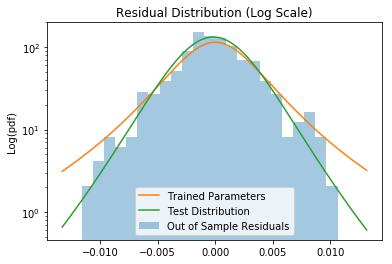

In [47]:
sns.distplot(err,kde=False,norm_hist=True,label="Out of Sample Residuals")
plt.plot(r,pdf_train,label="Trained Parameters")
plt.plot(r,pdf_test,label="Test Distribution")
plt.legend()
ax=plt.gca()
ax.set_yscale("log", nonposy='clip')
plt.title("Residual Distribution (Log Scale)")
plt.ylabel("Log(pdf)")

## Conclusions

1. The auto of sample predictions of  the least squared and t-student estimator **are very similar**.
2. If you try other index pairs (by changing `predictor` and `target` variables at the begining of notebook) you will find most pairs are even closer.
3. In this time period t-student estimator has better likelihood and R^2 out of sample, but this depends on the period chosen.
4. If the assumptions of the t-student model where satisfied:
    1.1 $\epsilon_t$ identically distributed t-Student random variable.
    1.2 $\epsilon_t$, $\epsilon_{t'}$ independent
  we would expect the max likelihood estimator to be *efficient* and produce good results.

However, it is easy to verify that **assumptions are not satisfied**

Although the autocorrelation function shows that  returns are uncorrelated for $t\ne t'$ 

Text(0,0.5,'Correlation')

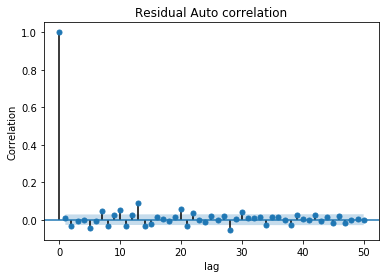

In [48]:
s=statsmodels.graphics.tsaplots.plot_acf(train_err,lags=50,title="Residual Auto correlation")
plt.xlabel("lag")
plt.ylabel("Correlation")

The returns for different dates are clearly **not independent**.

Return variance (volatility) seems to depend on time, and there is **volatility clustering**

Text(0,0.5,'return')

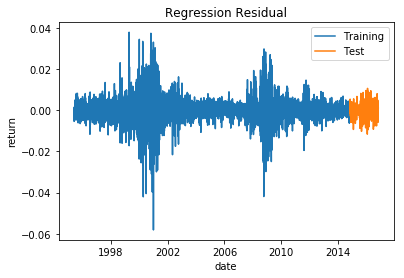

In [49]:
plt.plot(train_err,label="Training")
plt.plot(err,label="Test")
plt.legend()
plt.title("Regression Residual")
plt.xlabel("date")
plt.ylabel("return")

Equity returns are more realisticallly modeled as a **GARCH** process.

A GARCH(1,1), for example, process is defined as
\begin{align}
    y_t &= \theta_0 + \theta_1 x_t + \epsilon_t \\
    \epsilon_t &= \sigma_t \textrm{d}W_t \\
    \sigma^2_t &= \omega+\alpha_1 \epsilon^2_{t-1} + \beta_1 \sigma^2_{t-1}
\end{align}
where $\textrm{d}W_t \sim \mathcal{N}(0,1)$ and independent for $t\ne t'$.

Many generalizations are posible (with more lags GARCH(p,q), etc).

Now the fit will need maximize the probability of the innovations $z_t$, and the volatility $\sigma^2_t$ will depend on the previous return and previous level of volatility.

Analyzing this kind of model would take us too far into **time series analysis** territory.


    

However, the behaviour **at the tails** of the distribution is dominated by a few **rare events**, may be 3 or 4 on a 20 year period.

It is problematic to fit a rich model with so few relevant observations.
